In [239]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [124]:
words = open('./names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [125]:
chars = sorted(list(set(''.join(words)))) #lol
token_lookup = {c: i+1 for i, c in enumerate(chars)}
token_lookup['.'] = 0
char_lookup = {i:c for c, i in token_lookup.items()}
TOTAL_TOKENS = len(char_lookup.keys())

In [240]:
# build the dataset

BLOCK_SIZE = 3 # context size to give the model in order to predict the next character

def build_dataset(corpus, block_size, codebook, padding_char="."):
    X, Y = [], []
    for word in corpus:
        start_padding = padding_char * block_size
        padded_word = f"{start_padding}{word}."
        tokenized_word = [codebook[c] for c in padded_word]
        for i in range(len(tokenized_word)-block_size):
            X.append(tokenized_word[i:i+block_size])
            Y.append(tokenized_word[i+block_size])
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

x_train, y_train = build_dataset(words[:n1], BLOCK_SIZE, token_lookup)
x_valid, y_valid = build_dataset(words[n1:n2], BLOCK_SIZE, token_lookup)
x_test, y_test = build_dataset(words[n2:], BLOCK_SIZE, token_lookup)

In [266]:
TOTAL_NEURONS = 200
EMBEDDING_DIMS = 10 # embed 27 characters into N dimensional space

C = torch.randn((TOTAL_TOKENS, EMBEDDING_DIMS))
W1 = torch.randn((EMBEDDING_DIMS * BLOCK_SIZE, TOTAL_NEURONS))
b1 = torch.randn((TOTAL_NEURONS,))
W2 = torch.randn(TOTAL_NEURONS, TOTAL_TOKENS)
b2 = torch.randn((TOTAL_TOKENS,))
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    p.to('cuda')

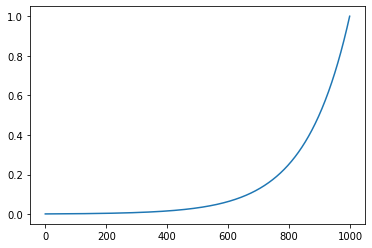

In [215]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
plt.plot(lrs)

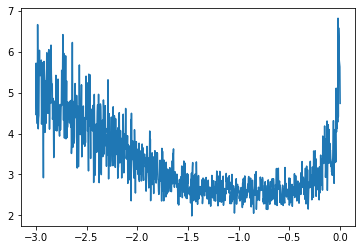

In [220]:
steps = 1000
BATCH_SIZE = 512
loss_history = []

for t in range(steps):
    # forward pass
    batch_ix = torch.randint(0, x_train.shape[0], (32,))
    embeddings = C[x_train[batch_ix]]
    cat_embeddings = embeddings.view(-1, EMBEDDING_DIMS * BLOCK_SIZE)
    hidden_states_01 = torch.tanh(cat_embeddings @ W1 + b1)
    logits = hidden_states_01 @ W2 + b2
    loss = F.cross_entropy(logits, y_train[batch_ix])
    loss_history.append(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[t]
    for p in parameters:
        p.data += -lr * p.grad
plt.plot(lre, loss_history)


In [270]:
steps = 2000
print_steps = 500
BATCH_SIZE = 256
lrs = [1e-3]

for lr in lrs: # janky decay
    for t in range(steps):
        # forward pass
        batch_ix = torch.randint(0, x_train.shape[0], (32,))
        embeddings = C[x_train[batch_ix]]
        cat_embeddings = embeddings.view(-1, EMBEDDING_DIMS * BLOCK_SIZE)
        hidden_states_01 = torch.tanh(cat_embeddings @ W1 + b1)
        logits = hidden_states_01 @ W2 + b2
        loss = F.cross_entropy(logits, y_train[batch_ix])
        if t % print_steps == 0:
            print(f'step {t}: {loss.item()}')
        #backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        for p in parameters:
            p.data += -lr * p.grad


step 0: 1.9271050691604614
step 500: 2.1899304389953613
step 1000: 2.398402690887451
step 1500: 2.1608669757843018


In [271]:
# clculate training and validation loss
@torch.no_grad
def calc_loss(x_target, y_target):
    emb = C[x_target].view(-1, EMBEDDING_DIMS * BLOCK_SIZE)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_target)
    return loss

calc_loss(x_train, y_train), calc_loss(x_valid, y_valid)

(tensor(2.2125, grad_fn=<NllLossBackward0>),
 tensor(2.2486, grad_fn=<NllLossBackward0>))

In [287]:
# sample

def sample():
    tokens = [0] * BLOCK_SIZE
    while True:
        emb = C[torch.tensor(tokens[-BLOCK_SIZE:])].view(-1, EMBEDDING_DIMS * BLOCK_SIZE)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        tokens.append(ix)
        if ix == 0:
            break
    return "".join([char_lookup[t] for t in tokens][BLOCK_SIZE:-1])

for i in range(20):
    print(sample())

amyaan
radal
brena
zusicka
bralahier
ozi
augratiyah
jaok
piz
davartavyn
ler
barolanah
yoriyah
jane
pux
gernettelenan
jandae
dis
maxsirin
kay


In [9]:
a = -torch.tensor(1/27.).log()
logits = torch.tensor([100.,0.,5.,0.])
probs = torch.softmax(logits, dim=0)
probs, -probs[2].log()

(tensor([1.0000e+00, 3.7835e-44, 5.5211e-42, 3.7835e-44]), tensor(95.0000))